# Construção do modelo ARIMA

## Bibliotecas necessárias

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

## Leitura dos dados

In [8]:
def read_data(country):
    dir_covid_data = '../../datalake/silver/covid_data/series_with_calc_fields'
    covid_file = f'{dir_covid_data}/{country}.parquet'
    covid_data = pd.read_parquet(covid_file)
    covid_data['date'] = pd.to_datetime(covid_data.date)
    covid_data = covid_data[((covid_data.date > "2020-01-01") & (covid_data.date < "2020-7-31"))]
    covid_data.set_index('date', inplace=True)
    reg_data = covid_data[['New_Confirmed']].dropna() # Remoção de valores NaN
    return reg_data

Função para gerar os modelos AR, MA e ARIMA

In [34]:
from sklearn.metrics import mean_absolute_error, r2_score

def arima_model(train_data, test_data, p=0, d=0, q=0, country='', model_name='',
                save_model=False):
    
    model = ARIMA(train_data['New_Confirmed'], order=(p, d, q))
    model = model.fit()
    print(model.summary())
    
    fcst = pd.DataFrame([])
    data = train_data.copy()
    pred = model.predict(start=0, end=len(train_data['New_Confirmed'])-1)
    print('MAE treino:', mean_absolute_error(pred, train_data))
    print('R2:', r2_score(train_data, pred))
    
    for i in range(len(test_data)):
        fcst = pd.concat([fcst, model.forecast()])
        data = pd.concat([data, test_data.iloc[i:i+1]])
        model_test = ARIMA(data['New_Confirmed'], order=(p, d, q))
        model = model_test.smooth(model.params)
    
    # if save_model:
    #     model.save(f'D:/bootcamp-covid/model/arima_{save_model}.pkl')
    print('MAE validação:', mean_absolute_error(test_data, fcst))
    print('R2:', r2_score(test_data, fcst))
    print('='*100)
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    plt.plot(train_data['New_Confirmed'], label='Dados de treino', marker='.')
    plt.plot(pred, label='Treino predito')
    plt.plot(fcst, label='Previstos da série teste')
    plt.plot(test_data, label='Série de teste')
    plt.legend()
    plt.title(f'Modelo {model_name} para o {country}');
    

In [35]:

def sarima_model_plot(train_data, test_data, p=0, d=0, q=0, P=0, D=0, Q=0, m=0, country='', model_name=''):
    model = ARIMA(train_data['New_Confirmed'], order=(p, d, q), seasonal_order=(P, D, Q, m))
    model = model.fit()
    print(model.summary())
    
    fcst = pd.DataFrame([])
    data = train_data.copy()
    pred = model.predict(start=0, end=len(train_data['New_Confirmed'])-1)
    print('MAE treino:', mean_absolute_error(pred, train_data))
    print('R2:', r2_score(train_data, pred))
    
    for i in range(len(test_data)):
        fcst = pd.concat([fcst, model.forecast()])
        data = pd.concat([data, test_data.iloc[i:i+1]])
        model_test = ARIMA(data['New_Confirmed'], order=(p, d, q), seasonal_order=(P, D, Q, m))
        model = model_test.smooth(model.params)
    
    print('MAE validação:', mean_absolute_error(test_data, fcst))
    print('R2:', r2_score(test_data, fcst))
    print('='*100)
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    plt.plot(train_data['New_Confirmed'], label='Dados de treino')
    plt.plot(pred, label='Treino predito')
    plt.plot(fcst, label='Previstos da série teste')
    plt.plot(test_data, label='Série de teste')
    plt.legend()
    plt.title(f'Modelo {model_name} para o {country}');
    

## Modelagem por país

### ARGENTINA

#### Configuração dos dados para o modelo.

Seleção dos dados de casos diários referentes a Argentina.

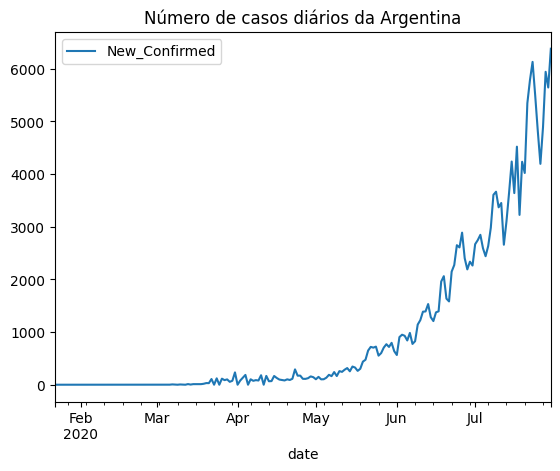

In [9]:
reg_data_ar = read_data('AR')
reg_data_ar.plot()
plt.title('Número de casos diários da Argentina');

In [9]:
reg_data_ar.head()

,New_Confirmed
date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


No início da série existem vários valores iguais a zero. A existência desses valores zeros no início da série é devido a inesistência de COVID no começo. A série de casos de COVID começa, de fato, a partir do momento em que é registrado o primeiro caso. Assim, foram removidos os registros nulos anteriores a data em que aparece o primeiro registro de casos.

Remoção dos primeiros registros nulos.

In [31]:
reg_data_ar.ge(100).idxmax()

New_Confirmed   2020-03-22
dtype: datetime64[ns]

<AxesSubplot:xlabel='date'>

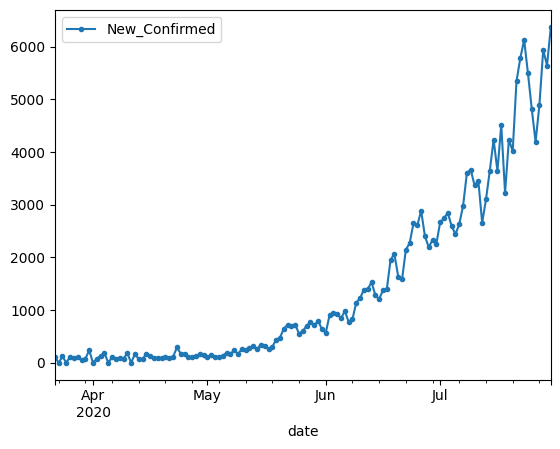

In [13]:
reg_data_ar = reg_data_ar.loc[reg_data_ar.ge(100).idxmax()[0]:]
reg_data_ar.plot(marker='.')

Vê-se então que, para o caso da Argentina, a pandemia de COVID inicou em 3 de março de 2020.

Serão separados os 70% primeiros registros para treino do modelo e o restante para teste. 
A seguir a quantidade de registros para os grupos de treino e teste.

In [14]:
print('Total de registros:', len(reg_data_ar))
print('Número de registros para treino:', round(len(reg_data_ar)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_ar)*0.3, 0))

Total de registros: 131
Número de registros para treino: 92.0
Número de registros para teste: 39.0


Separação dos grupos de treino e teste para a Argentina.

In [15]:
train_data = reg_data_ar.iloc[:92]
test_data = reg_data_ar.iloc[92:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 92
Número de registros para teste final: 39


Antes de implementar o modelo ARIMA completo serão testadas duas variações, mais simples do mesmo. O modelo AR (autoregressivo) e o modelo MA (médias móveis).

#### Modelo AR (Auto Regressivo)

Para o modelo AR é necessário saber o valor do termo autoregressivo. Tal termo é obtido a partir da análise da autocorrelação parcial da série. A seguir é plotado o gráfico da autocorrelação parcial para a Argentina.

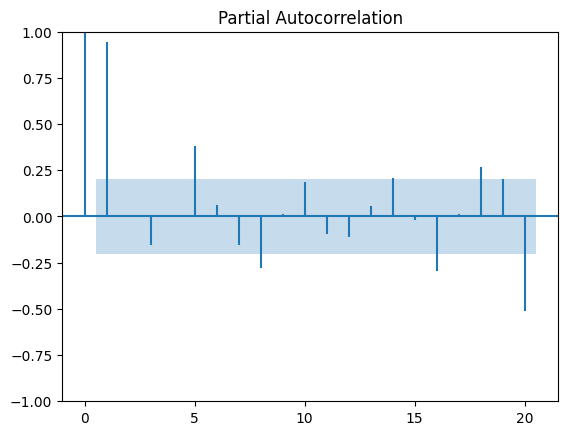

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New_Confirmed'], marker='');

Segundo o gráfico acima o termo autoregressivo de significância estatística é o de ordem 1. Assim o modelo AR a ser construído será de ordem 1. O método ARIMA do statsmodels permite construir modelos AR definido apenas o valor do termo Autoregressivo e definido o valor dos outros termos do modelo como sendo iguais a zero.

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                   92
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -577.998
Date:                Wed, 18 Jan 2023   AIC                           1161.997
Time:                        20:20:04   BIC                           1169.562
Sample:                    03-22-2020   HQIC                          1165.050
                         - 06-21-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        652.1782    509.222      1.281      0.200    -345.879    1650.236
ar.L1          0.9784      0.021     47.444      0.000       0.938       1.019
sigma2      1.621e+04   1376.346     11.775      0.0

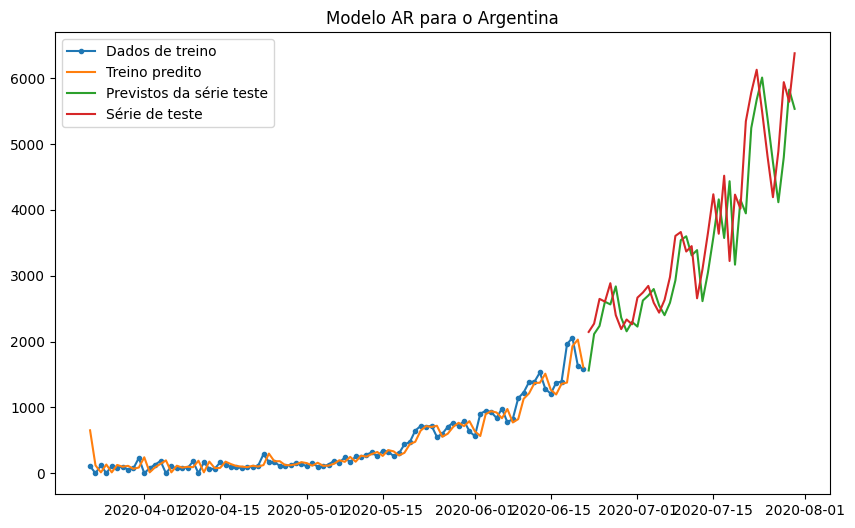

In [36]:
# Definição do modelo AR para a Argentina
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
arima_model(train_data, test_data, p=1, model_name='AR', country='Argentina')

Gráfico de comparação entre o modelado e o observado. Neste caso o modelo utiliza dados do dia anterior (AR de ordem 1) e prevê para 1 dia. 

#### Modelo MA (Médias Móveis)

Assim como o AR é necessário calcular o termo de MA. Tal termo pode ser obtido a partir da análise do gráfico de autocorrelação a seguir.

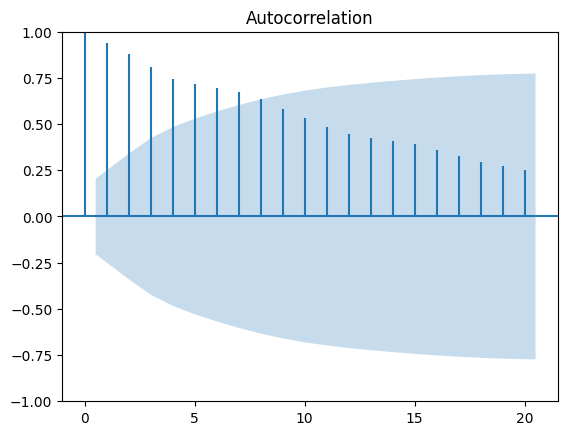

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New_Confirmed'],  marker='');

Segundo o gráfico acima o termo MA para o modelo é 7. Pois, a correlação dos 7 primeiros lags está acima do intervalo de confiança de 95% (área sombreada). 

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                   92
Model:                 ARIMA(0, 0, 7)   Log Likelihood                -595.285
Date:                Wed, 18 Jan 2023   AIC                           1208.570
Time:                        20:20:41   BIC                           1231.266
Sample:                    03-22-2020   HQIC                          1217.730
                         - 06-21-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        463.5296    129.190      3.588      0.000     210.321     716.738
ma.L1          1.0352     15.199      0.068      0.946     -28.755      30.825
ma.L2          0.9520     15.969      0.060      0.9

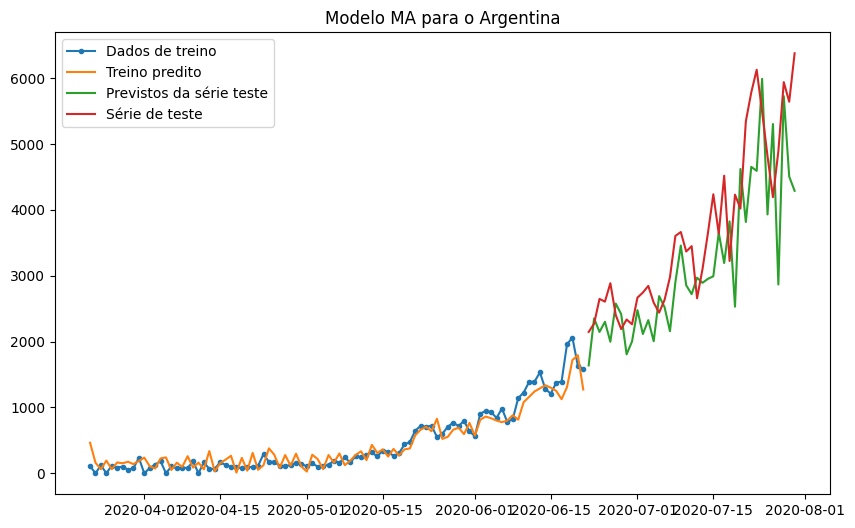

In [37]:
arima_model(train_data, test_data, q=7, model_name='MA', country='Argentina')

Considerando o AIC o AR obteve melhor resultado que o MA pois obteve AIC menor.

Nítidamente o modelo AR foi superior ao MA.

#### Modelo ARIMA

Da mesma forma que os modelos anteriores os AR e MA é necessário estimar os valores dos termos do modelo.
Além dos termos AR e MA o ARIMA tabém conta com o termo de diferenciação (d).
A diferenciação é utilizada para transformar a série temporal em uma série estacionária.
O teste de Fuller é um dos métodos utilizados para estimar se uma série temporal é estacionária ou não.

In [20]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train_data['New_Confirmed'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 4.349557
p-value: 1.000000


Como o resultado o p-valor é superior a 0,05 pode-se descartar a hipótese de que a série e estacionária e por isso será necessário diferenciar a série até que se obtenha uma série estacionária como se segue.

In [21]:
def plot_diffs():
    # Original Series
    fig, axes = plt.subplots(4, 3, figsize=(20, 10))
    axes[0, 0].plot(train_data['New_Confirmed']); 
    axes[0, 0].set_title('Original Series')
    plot_acf(train_data['New_Confirmed'], ax=axes[0, 1], marker='')
    plot_pacf(train_data['New_Confirmed'], ax=axes[0, 2], marker='')
    result = adfuller(train_data['New_Confirmed'])
    print('ADF Statistic 0 Order: %f' % result[0])
    print('p-value: %f' % result[1])


    # 1st Differencing
    axes[1, 0].plot(train_data['New_Confirmed'].diff()); 
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(train_data['New_Confirmed'].diff().dropna(), ax=axes[1, 1], marker='')
    plot_pacf(train_data['New_Confirmed'].diff().dropna(), ax=axes[1, 2], marker='')
    result = adfuller(train_data['New_Confirmed'].diff().dropna())
    print('ADF Statistic 1st Order: %f' % result[0])
    print('p-value: %f' % result[1])


    # # 2nd Differencing
    axes[2, 0].plot(train_data['New_Confirmed'].diff().diff()); 
    axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(train_data['New_Confirmed'].diff().diff().dropna(), ax=axes[2, 1], marker='')
    plot_pacf(train_data['New_Confirmed'].diff().diff().dropna(), ax=axes[2, 2], marker='')
    result = adfuller(train_data['New_Confirmed'].diff().diff().dropna())
    print('ADF Statistic 2nd Order: %f' % result[0])
    print('p-value: %f' % result[1])

    # # 3th Differencing
    axes[3, 0].plot(train_data['New_Confirmed'].diff().diff().diff()); 
    axes[3, 0].set_title('3nd Order Differencing')
    plot_acf(train_data['New_Confirmed'].diff().diff().diff().dropna(), ax=axes[3, 1], marker='')
    plot_pacf(train_data['New_Confirmed'].diff().diff().diff().dropna(), ax=axes[3, 2], marker='')
    result = adfuller(train_data['New_Confirmed'].diff().diff().diff().dropna())
    print('ADF Statistic 3th order: %f' % result[0])
    print('p-value: %f' % result[1])

    plt.show()
    

ADF Statistic 0 Order: 4.349557
p-value: 1.000000
ADF Statistic 1st Order: -1.804635
p-value: 0.378163
ADF Statistic 2nd Order: -6.866858
p-value: 0.000000
ADF Statistic 3th order: -6.327233
p-value: 0.000000


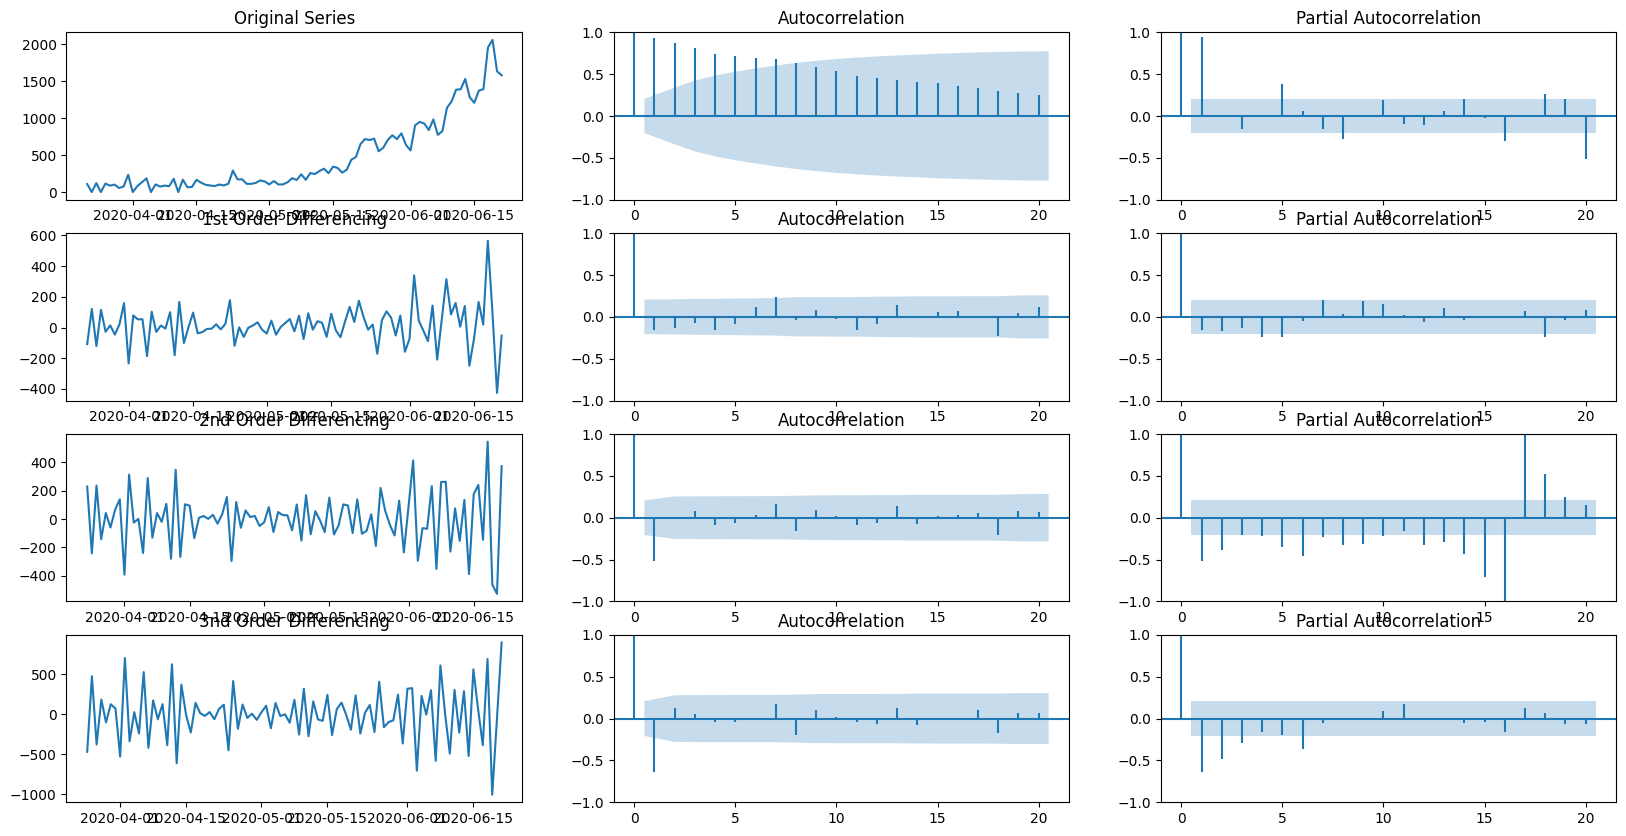

In [22]:
plot_diffs()

Com a diferenciação de segunda ordem já se obteve uma série temporal. O termo MA será 1. O termo AR será de 3.

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                   92
Model:                 ARIMA(1, 2, 7)   Log Likelihood                -555.142
Date:                Wed, 18 Jan 2023   AIC                           1128.284
Time:                        20:20:58   BIC                           1150.783
Sample:                    03-22-2020   HQIC                          1137.357
                         - 06-21-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1295      0.541      0.239      0.811      -0.932       1.191
ma.L1         -1.4854      0.539     -2.754      0.006      -2.543      -0.428
ma.L2          0.3717      0.715      0.520      0.6

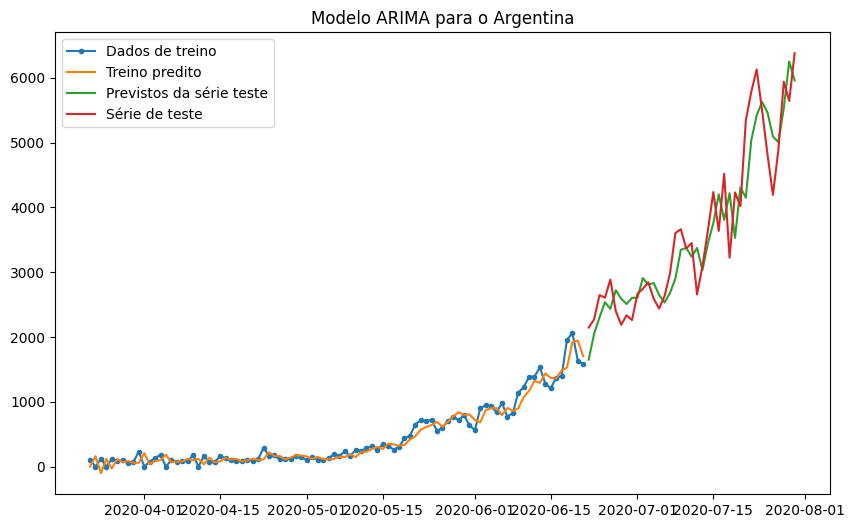

In [38]:
arima_model(train_data, test_data, p=1, d=2, q=7, model_name='ARIMA', country='Argentina', save_model='AR')

In [ ]:
MAE treino: 87.51666712889354
R2: 0.9477664169155489
MAE validação: 378.78123487093296
R2: 0.8337986912482093

A redução do AIC indica que o ARIM(3, 2, 1) têm desempenho melhor que o AR(1).

A seguir seguem os mesmos procedimentos para os demais países.

In [24]:
from pmdarima.arima import auto_arima

In [30]:
sarima_model = auto_arima(train_data,
                          start_p = 1, max_p = 7,
                          d = 1, max_d = 3,
                          start_q = 1, max_q = 7,
                          start_P = 1, max_P = 7,
                          D = 1, max_D = 3,
                          start_Q = 1, max_Q = 7,
                          m = 7, 
                          max_order = 14*3,
                          seasonal = True,
                          erro_action = 'warn',
                          trace = False,
                          supress_warnings = True,
                          stepwise = True,
                          random_state = 21,
                          n_fits = 100
                          )

AIC                           1200.545
BIC                           1213.620

In [31]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   92
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood                -514.477
Date:                           Wed, 18 Jan 2023   AIC                           1040.953
Time:                                   20:17:33   BIC                           1055.538
Sample:                               03-22-2020   HQIC                          1046.816
                                    - 06-21-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.7825      1.136      4.210      0.000       2.556       7.009
ma.L1         -0.5134      0.090     -5.696      0.000      -0.690      -0.337
ma.L2         -0.2747      0.116     -2.368      0.018      -0.502      -0.047
ma.S.L7       -0.5389      0.134     -4.031      0.000      -0.801      -0.277
ma.S.L14      -0.2211      0.228     -0.968      0.333      -0.669       0.227
sigma2      1.134e+04   1681.498      6.744      0.000    8043.549    1.46e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.41
Prob(Q):                              0.98   Prob(JB):                         0.01
Heteroskedasticity (H):               2.45   Skew:                             0.54
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                                    SARIMAX Results                                    
Dep. Variable:                   New_Confirmed   No. Observations:                   92
Model:             ARIMA(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood                -517.741
Date:                         Wed, 18 Jan 2023   AIC                           1045.482
Time:                                 20:22:22   BIC                           1057.637
Sample:                             03-22-2020   HQIC                          1050.368
                                  - 06-21-2020                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4574      0.087     -5.235      0.000      -0.629      -0.286
ma.L2         -0.1577      0.113     -1.390      0.164     

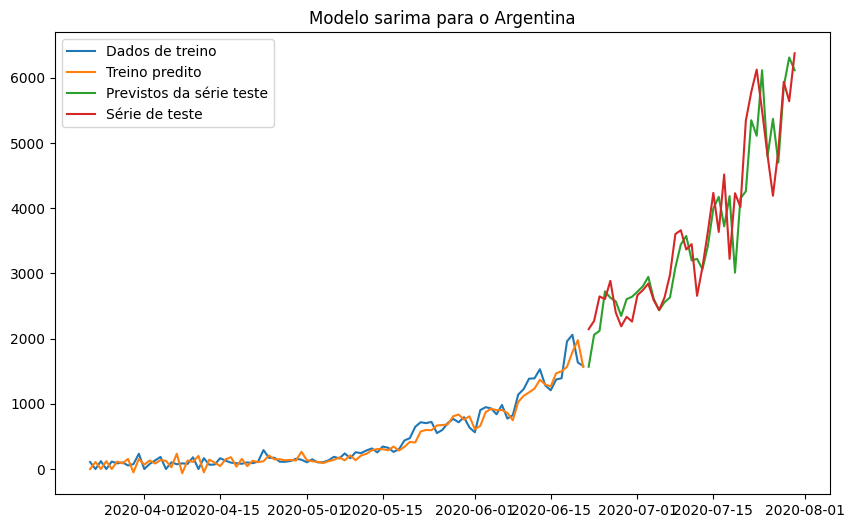

In [41]:
sarima_model_plot(train_data, test_data, p=0, d=1, q=2, P=0, D=1, Q=2, m=7, country='Argentina', model_name='sarima')

### México

#### Preparação dos dados

In [43]:
reg_data_mx = read_data('MX')
reg_data_mx

,New_Confirmed
date,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0
...,...
2020-07-26,5480.0
2020-07-27,4973.0
2020-07-28,7208.0


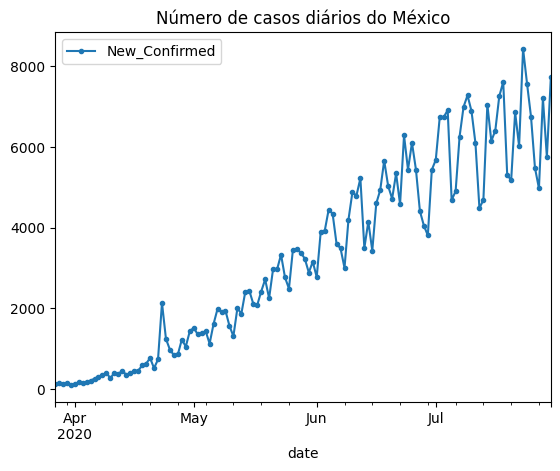

In [44]:
reg_data_mx = reg_data_mx.loc[reg_data_mx.ge(100).idxmax()[0]:]
reg_data_mx.plot(marker='.')
plt.title('Número de casos diários do México');

In [45]:
print('Total de registros:', len(reg_data_mx))
print('Número de registros para treino:', round(len(reg_data_mx)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_mx)*0.3, 0))

Total de registros: 126
Número de registros para treino: 88.0
Número de registros para teste: 38.0


In [46]:
train_data = reg_data_mx.iloc[:88]
test_data = reg_data_mx.iloc[88:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 88
Número de registros para teste final: 38


#### Modelo AR (Autoregressivo)

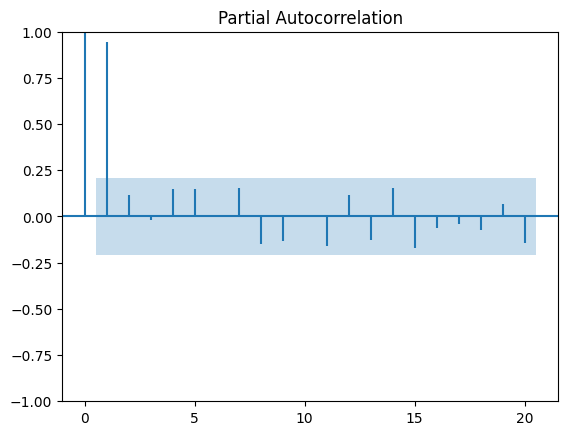

In [47]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New_Confirmed'], marker='');

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                   88
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -668.076
Date:                Wed, 18 Jan 2023   AIC                           1342.151
Time:                        20:24:35   BIC                           1349.583
Sample:                    03-27-2020   HQIC                          1345.145
                         - 06-22-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2098.2618   1199.191      1.750      0.080    -252.110    4448.634
ar.L1          0.9640      0.032     30.192      0.000       0.901       1.027
sigma2      2.225e+05   2.65e+04      8.406      0.0

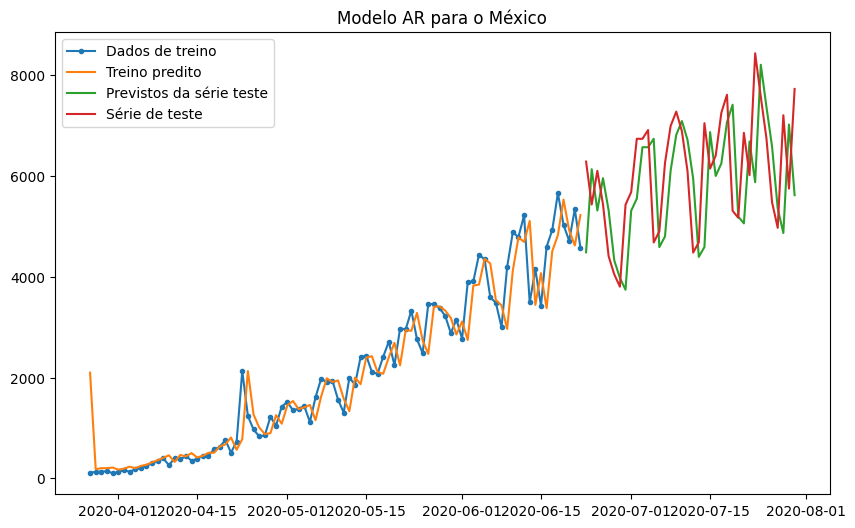

In [48]:
arima_model(train_data, test_data, p=1, model_name='AR', country='México')

#### Modelo MA (Médias Móveis)

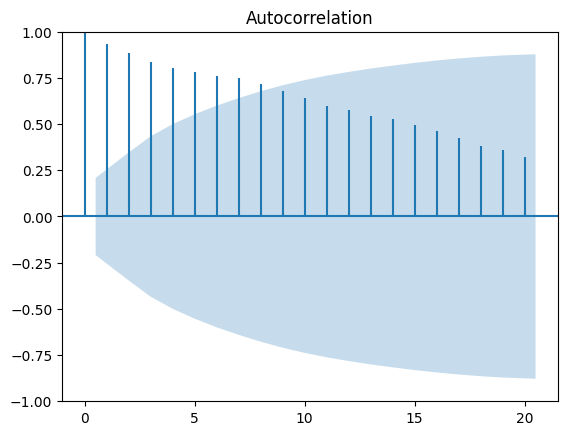

In [49]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New_Confirmed'],  marker='');

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                   88
Model:                 ARIMA(0, 0, 8)   Log Likelihood                -684.043
Date:                Wed, 18 Jan 2023   AIC                           1388.085
Time:                        20:25:00   BIC                           1412.859
Sample:                    03-27-2020   HQIC                          1398.066
                         - 06-22-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2098.3676    444.638      4.719      0.000    1226.893    2969.843
ma.L1          0.8581      0.736      1.166      0.243      -0.584       2.300
ma.L2          0.8133      1.290      0.630      0.5

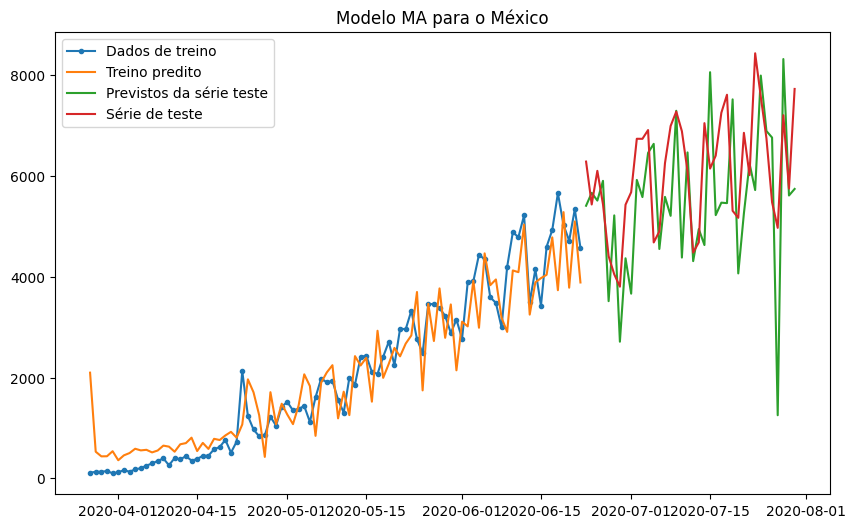

In [50]:
arima_model(train_data, test_data, q=8, model_name='MA', country='México')

#### Modelo ARIMA

In [51]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(train_data['New_Confirmed'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.186034
p-value: 0.998871


ADF Statistic 0 Order: 2.186034
p-value: 0.998871
ADF Statistic 1st Order: -9.191673
p-value: 0.000000
ADF Statistic 2nd Order: -4.692759
p-value: 0.000087
ADF Statistic 3th order: -9.346669
p-value: 0.000000


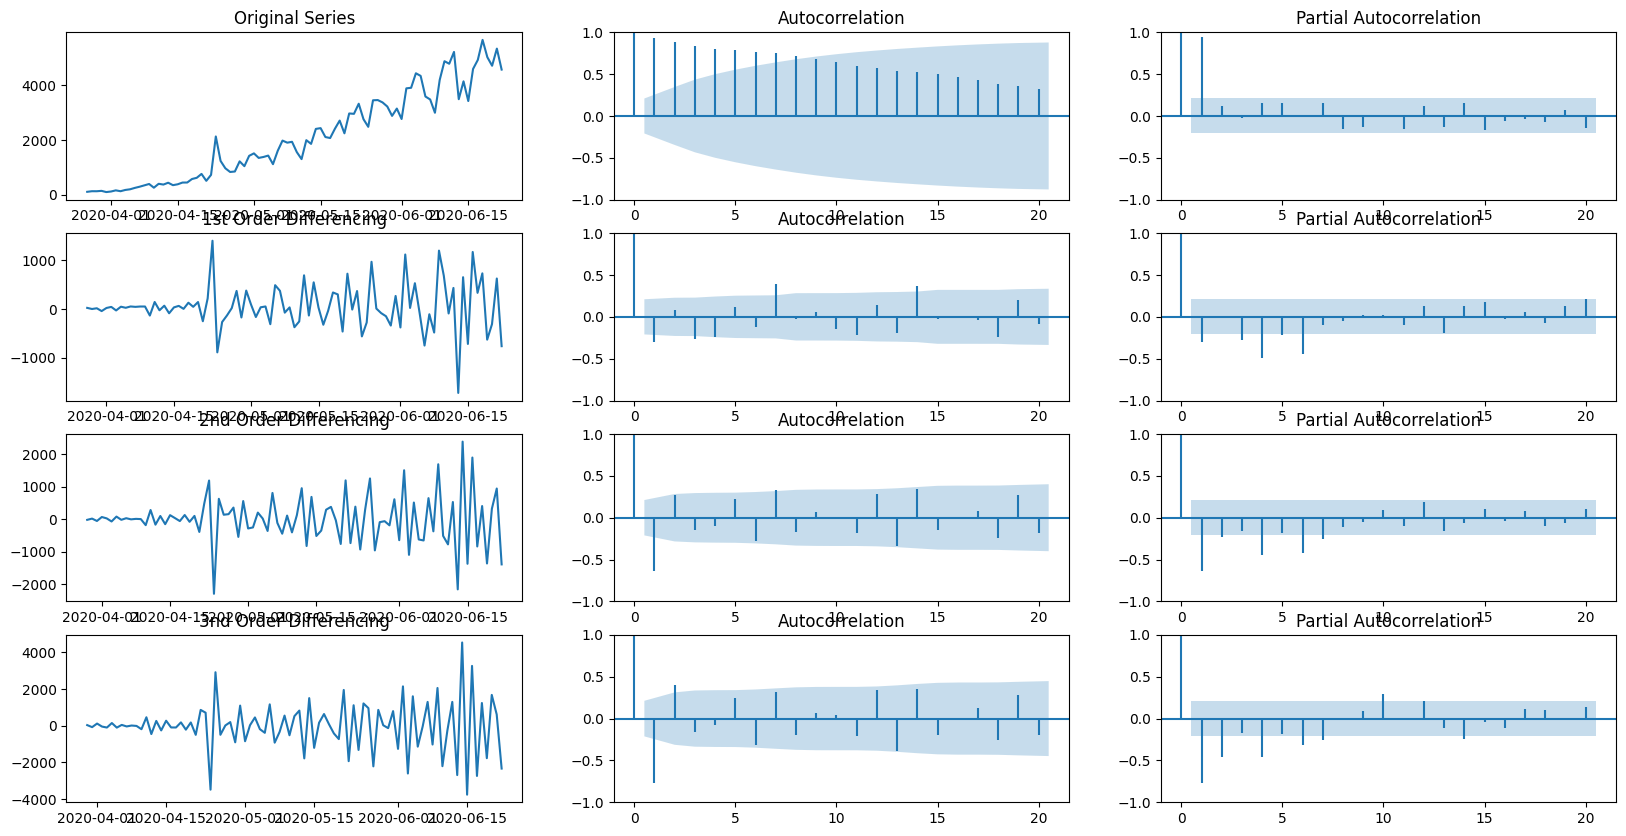

In [52]:
plot_diffs()

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                   93
Model:                 ARIMA(1, 1, 8)   Log Likelihood                -873.636
Date:                Wed, 18 Jan 2023   AIC                           1767.271
Time:                        21:03:46   BIC                           1792.489
Sample:                    03-20-2020   HQIC                          1777.449
                         - 06-20-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3253     11.492     -0.028      0.977     -22.848      22.198
ma.L1         -0.7992     10.817     -0.074      0.941     -22.001      20.403
ma.L2         -0.2043     12.324     -0.017      0.9

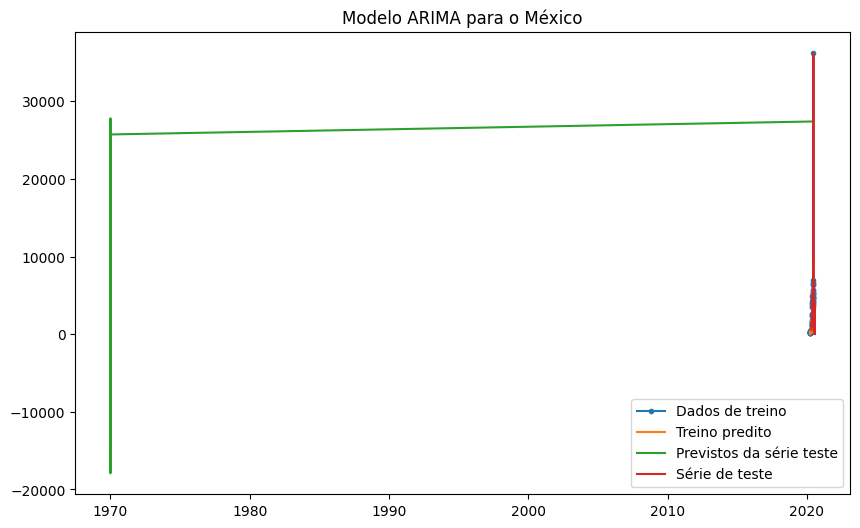

In [74]:
arima_model(train_data, test_data, p=1, d=1, q=8, model_name='ARIMA', country='México')

In [55]:
sarima_model = auto_arima(train_data,
                          start_p = 1, max_p = 7,
                          d = 1, max_d = 3,
                          start_q = 1, max_q = 7,
                          start_P = 1, max_P = 7,
                          D = 1, max_D = 3,
                          start_Q = 1, max_Q = 7,
                          m = 7, 
                          max_order = 14*3,
                          seasonal = True,
                          erro_action = 'warn',
                          trace = False,
                          supress_warnings = True,
                          stepwise = True,
                          random_state = 21,
                          n_fits = 100
                          )

In [56]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   88
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 7)   Log Likelihood                -580.803
Date:                            Wed, 18 Jan 2023   AIC                           1169.606
Time:                                    20:59:17   BIC                           1179.134
Sample:                                03-27-2020   HQIC                          1173.426
                                     - 06-22-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2113      0.143      1.475      0.140      -0.069       0.492
ma.L1         -0.8842      0.083    -10.637      0.000      -1.047      -0.721
ar.S.L7       -0.5457      0.091     -6.018      0.000      -0.723      -0.368
sigma2      1.138e+05   1.19e+04      9.596      0.000    9.06e+04    1.37e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                25.05
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.66
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

                                    SARIMAX Results                                     
Dep. Variable:                    New_Confirmed   No. Observations:                   88
Model:             ARIMA(1, 1, 1)x(1, 1, [], 7)   Log Likelihood                -580.803
Date:                          Wed, 18 Jan 2023   AIC                           1169.606
Time:                                  20:59:27   BIC                           1179.134
Sample:                              03-27-2020   HQIC                          1173.426
                                   - 06-22-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2113      0.143      1.475      0.140      -0.069       0.492
ma.L1         -0.8842      0.083    -10.637      0.

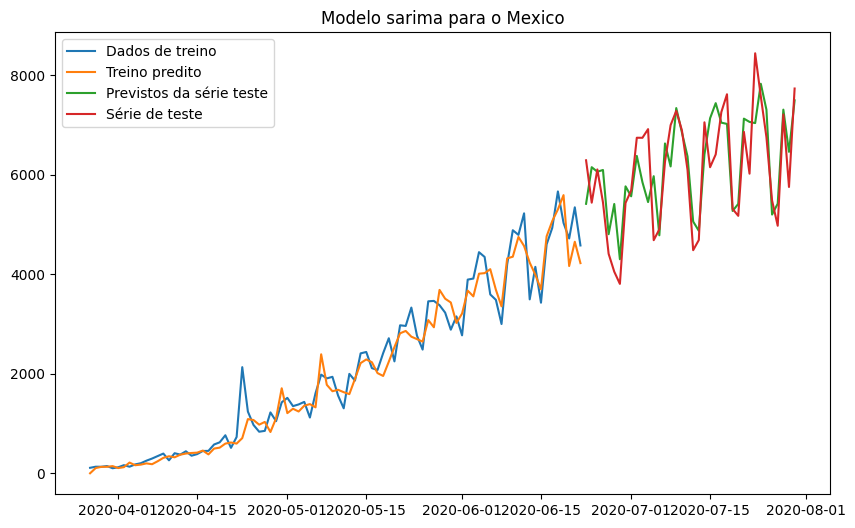

In [57]:
sarima_model_plot(train_data, test_data, p=1, d=1, q=1, P=1, D=1, Q=[], m=7, country='Mexico', model_name='sarima')

### Chile

#### Preparação dos dados

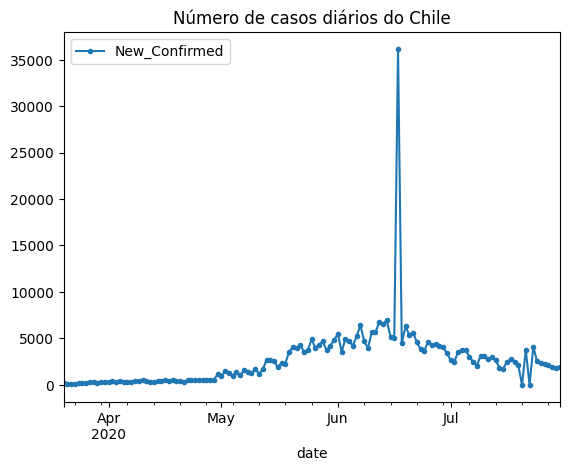

In [75]:
reg_data_ch = read_data('CH')
reg_data_ch = reg_data_ch[['New_Confirmed']]
reg_data_ch = reg_data_ch.loc[reg_data_ch.ge(100).idxmax()[0]:]
reg_data_ch.plot(marker='.')
plt.title('Número de casos diários do Chile');

In [77]:
print('Total de registros:', len(reg_data_ch))
print('Número de registros para treino:', round(len(reg_data_ch)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_ch)*0.3, 0))

Total de registros: 133
Número de registros para treino: 93.0
Número de registros para teste: 40.0


In [86]:
train_data = reg_data_ch.iloc[:93]
test_data = reg_data_ch.iloc[93:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 93
Número de registros para teste final: 40


#### Modelo AR

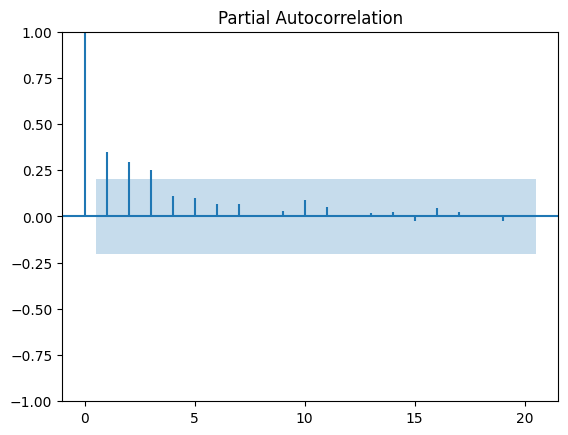

In [79]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New_Confirmed'], marker='');

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                   93
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -892.149
Date:                Wed, 18 Jan 2023   AIC                           1794.299
Time:                        21:10:08   BIC                           1806.962
Sample:                    03-20-2020   HQIC                          1799.412
                         - 06-20-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2543.1183   3948.284      0.644      0.520   -5195.377    1.03e+04
ar.L1          0.1723      0.086      2.011      0.044       0.004       0.340
ar.L2          0.2335      0.086      2.716      0.0

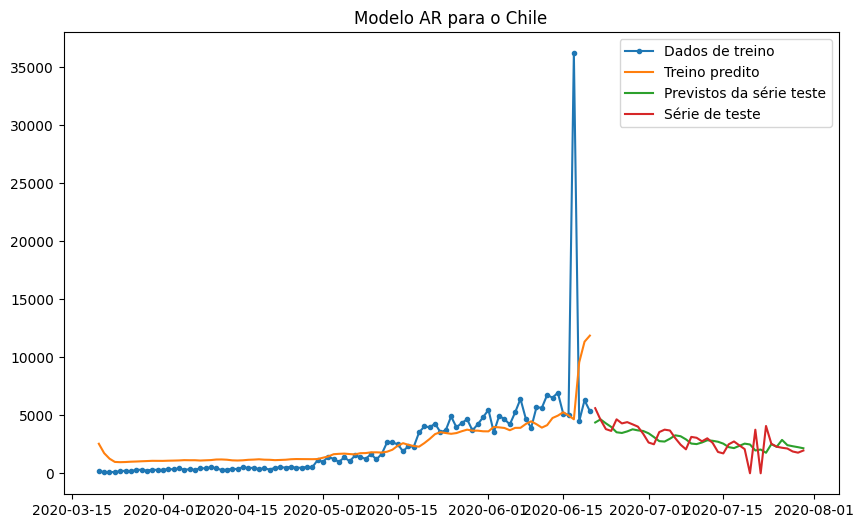

In [87]:
arima_model(train_data, test_data, p=3, model_name='AR', country='Chile')

#### Modelo MA

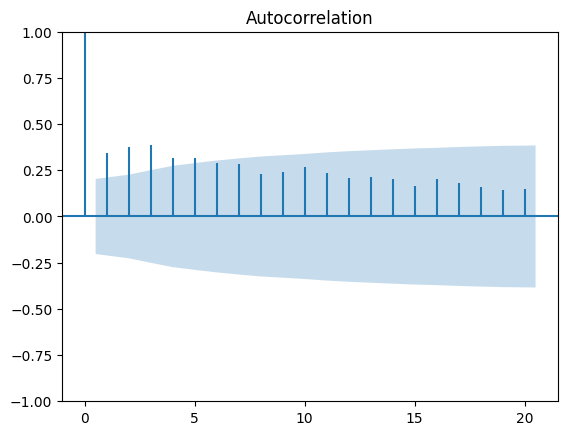

In [88]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New_Confirmed'],  marker='');

In [93]:
sarima_model = auto_arima(train_data,
                          start_p = 1, max_p = 7,
                          d = 1, max_d = 3,
                          start_q = 1, max_q = 7,
                          start_P = 1, max_P = 7,
                          D = 1, max_D = 3,
                          start_Q = 1, max_Q = 7,
                          m = 7, 
                          max_order = 14*3,
                          seasonal = True,
                          erro_action = 'warn',
                          trace = False,
                          supress_warnings = True,
                          stepwise = True,
                          random_state = 21,
                          n_fits = 100
                          )

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                   93
Model:                 ARIMA(0, 0, 7)   Log Likelihood                -891.788
Date:                Wed, 18 Jan 2023   AIC                           1801.575
Time:                        21:10:33   BIC                           1824.369
Sample:                    03-20-2020   HQIC                          1810.778
                         - 06-20-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2543.1185   4798.280      0.530      0.596   -6861.337    1.19e+04
ma.L1          0.0318      0.326      0.098      0.922      -0.607       0.671
ma.L2          0.0959      0.413      0.232      0.8

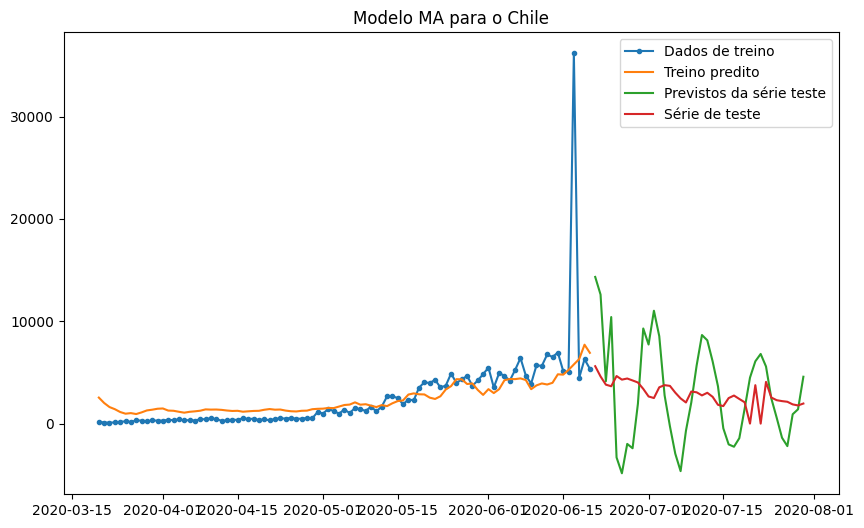

In [89]:
arima_model(train_data, test_data, q=7, model_name='MA', country='Chile')

#### Modelo ARIMA

ADF Statistic 0 Order: 1.581250
p-value: 0.997800
ADF Statistic 1st Order: -0.370084
p-value: 0.914975
ADF Statistic 2nd Order: -1.713271
p-value: 0.424288
ADF Statistic 3th order: -4.231860
p-value: 0.000582


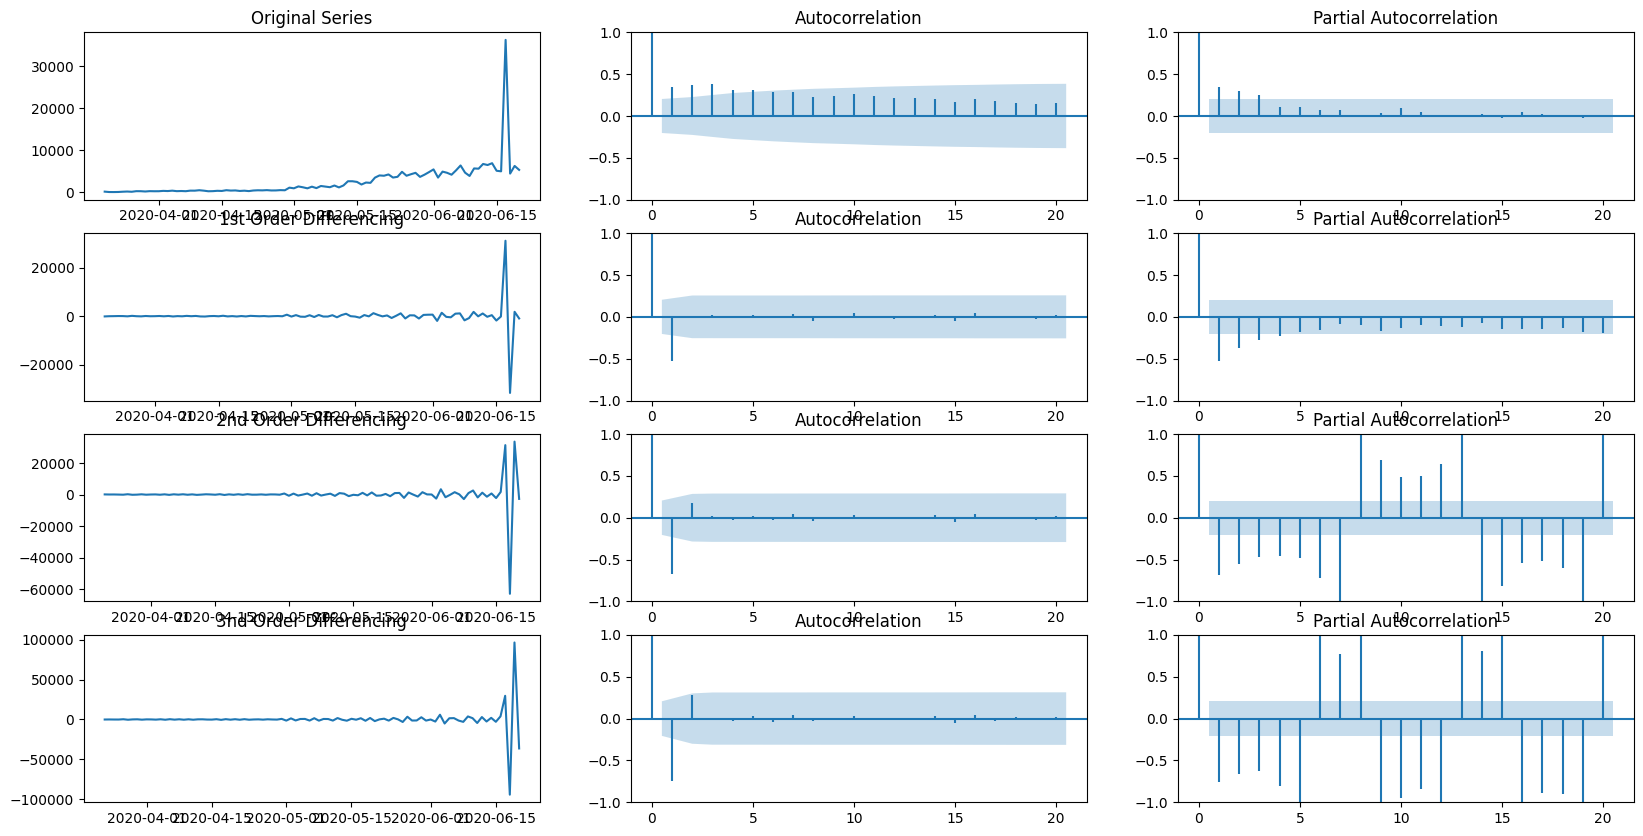

In [90]:
plot_diffs()

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                   93
Model:                 ARIMA(3, 3, 3)   Log Likelihood                -860.424
Date:                Wed, 18 Jan 2023   AIC                           1734.848
Time:                        21:11:08   BIC                           1752.347
Sample:                    03-20-2020   HQIC                          1741.904
                         - 06-20-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7028      1.163     -0.604      0.546      -2.983       1.577
ar.L2         -0.7830      0.811     -0.966      0.334      -2.372       0.806
ar.L3         -0.9272      0.916     -1.012      0.3

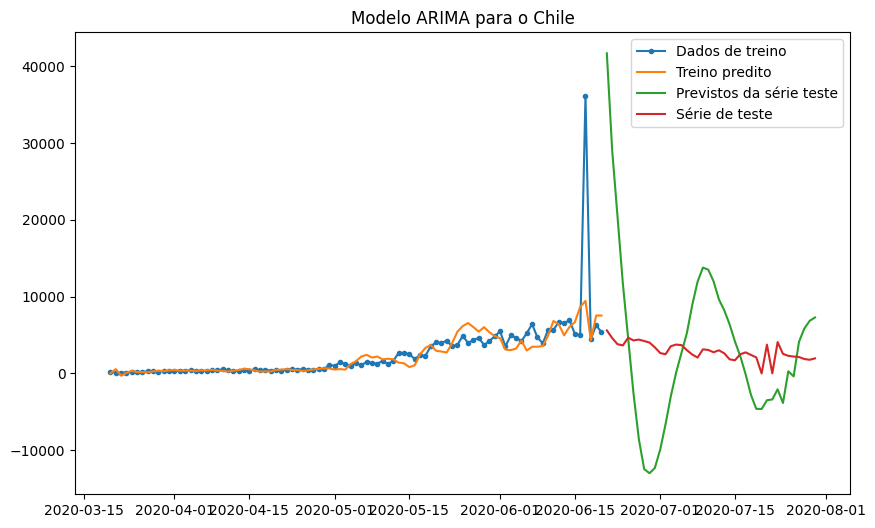

In [91]:
arima_model(train_data, test_data, p=3, d=3, q=3, model_name='ARIMA', country='Chile')

                                     SARIMAX Results                                     
Dep. Variable:                     New_Confirmed   No. Observations:                   93
Model:             ARIMA(3, 1, 4)x(0, 1, [1], 7)   Log Likelihood                -803.379
Date:                           Wed, 18 Jan 2023   AIC                           1624.758
Time:                                   21:11:25   BIC                           1646.742
Sample:                               03-20-2020   HQIC                          1633.600
                                    - 06-20-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3939      0.561     -0.702      0.483      -1.494       0.706
ar.L2         -0.8208      1.020     -0.805

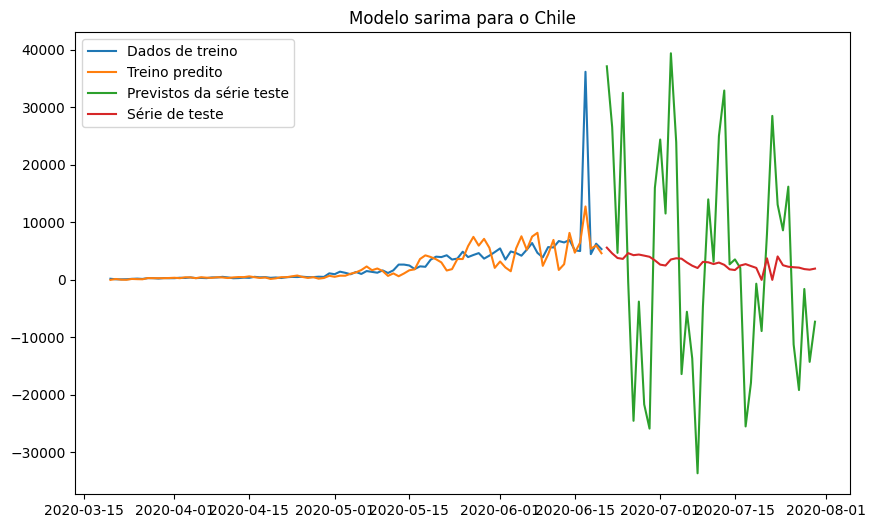

In [92]:
sarima_model_plot(train_data, test_data, p=3, d=1, q=4, P=0, D=1, Q=1, m=7, country='Chile', model_name='sarima')

### Equador

#### Preparação dos dados

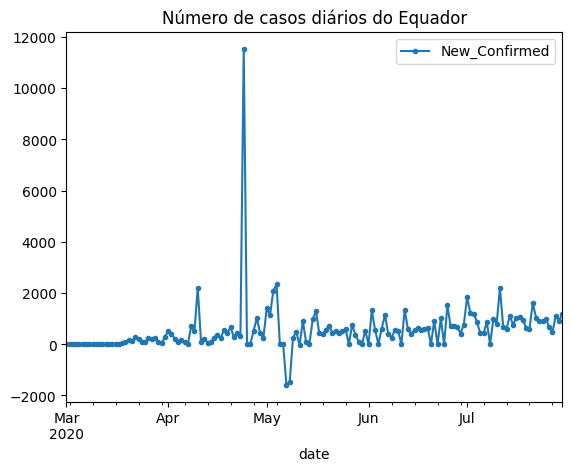

In [94]:
reg_data_eq = read_data('EC')
reg_data_eq = reg_data_eq.loc[reg_data_eq.ne(0).idxmax()[0]:]
reg_data_eq.plot(marker='.')
plt.title('Número de casos diários do Equador');

In [96]:
print('Total de registros:', len(reg_data_eq))
print('Número de registros para treino:', round(len(reg_data_eq)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_eq)*0.3, 0))

Total de registros: 152
Número de registros para treino: 106.0
Número de registros para teste: 46.0


In [97]:
train_data = reg_data_eq.iloc[:106]
test_data = reg_data_eq.iloc[106:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 106
Número de registros para teste final: 46


#### Modelo AR

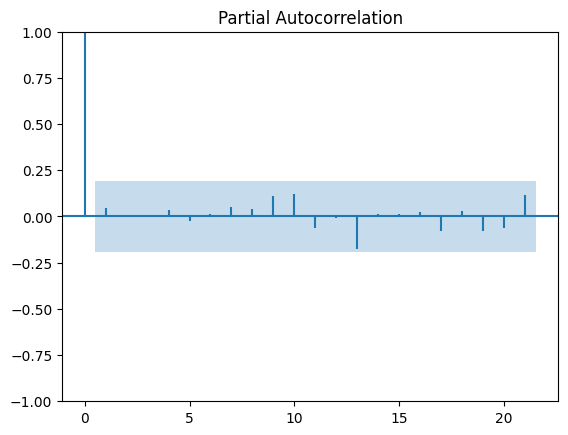

In [99]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New_Confirmed'], marker='');

Não há autocorrelação parcial então não se aplica este modelo mas ainda assim será testado o modelo AR(1).

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                  106
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -902.279
Date:                Wed, 18 Jan 2023   AIC                           1810.558
Time:                        21:17:02   BIC                           1818.548
Sample:                    03-01-2020   HQIC                          1813.796
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        441.0472    286.547      1.539      0.124    -120.575    1002.670
ar.L1          0.0450      0.125      0.359      0.719      -0.200       0.290
sigma2      1.461e+06   8.11e+04     18.011      0.0

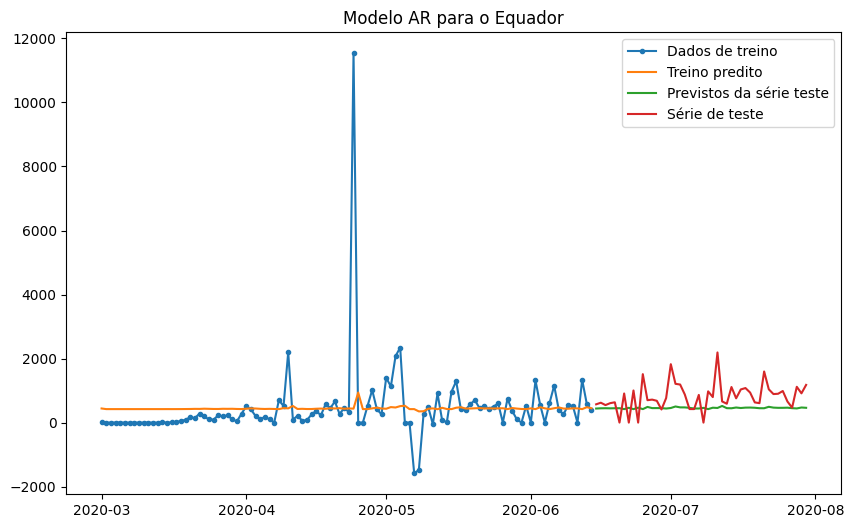

In [100]:
arima_model(train_data, test_data, p=1, model_name='AR', country='Equador')

#### Modelo MA

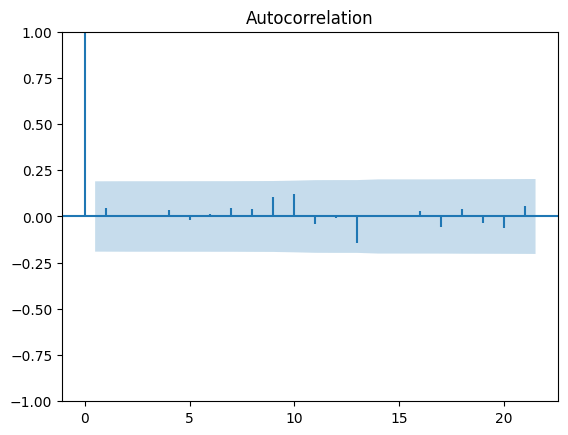

In [101]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New_Confirmed'], marker='');

                               SARIMAX Results                                
Dep. Variable:              New cases   No. Observations:                  104
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -883.750
Date:                Fri, 30 Dec 2022   AIC                           1773.500
Time:                        20:49:47   BIC                           1781.433
Sample:                    03-01-2020   HQIC                          1776.714
                         - 06-12-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        470.1058    343.320      1.369      0.171    -202.789    1143.000
ma.L1          0.0146      0.190      0.077      0.939      -0.357       0.386
sigma2      1.454e+06    9.9e+04     14.685      0.0

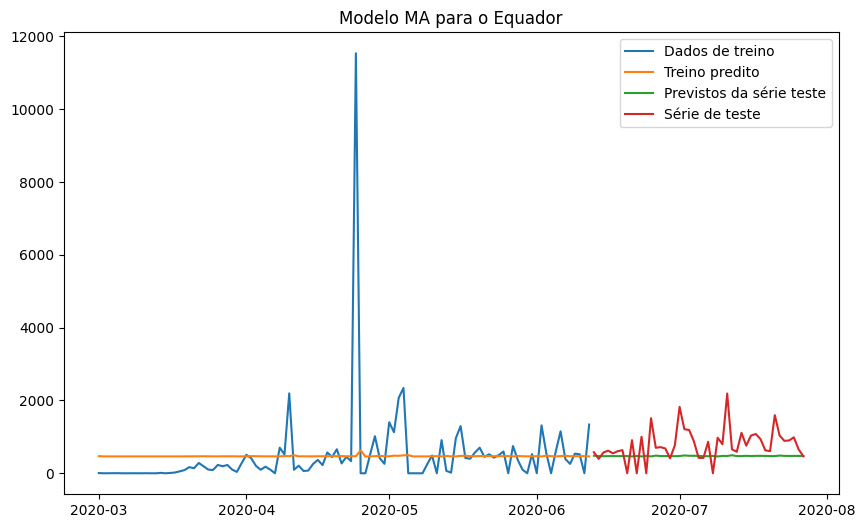

In [ ]:
arima_model(train_data, test_data, q=1, model_name='MA', country='Equador')

#### Modelo ARIMA

ADF Statistic 0 Order: -9.704679
p-value: 0.000000
ADF Statistic 1st Order: -6.245124
p-value: 0.000000
ADF Statistic 2nd Order: -7.424436
p-value: 0.000000
ADF Statistic 3th order: -7.210329
p-value: 0.000000


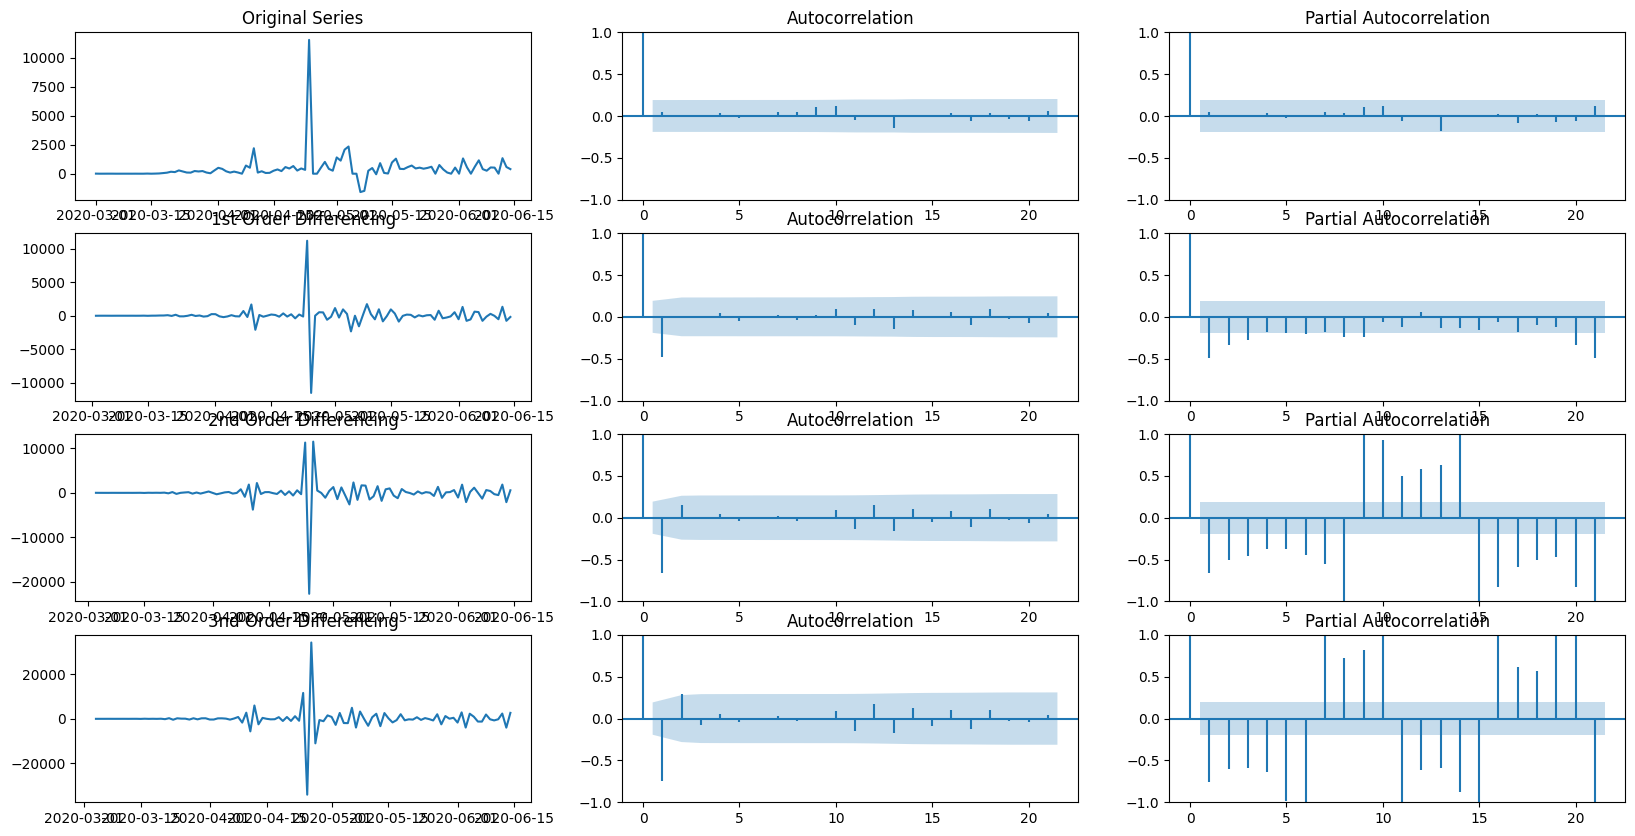

In [102]:
plot_diffs()

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                  106
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -896.020
Date:                Wed, 18 Jan 2023   AIC                           1802.039
Time:                        21:21:26   BIC                           1815.309
Sample:                    03-01-2020   HQIC                          1807.416
                         - 06-14-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      0.043    -23.403      0.000      -1.084      -0.916
ma.L1          0.0656      0.123      0.532      0.595      -0.176       0.307
ma.L2         -0.9547      0.065    -14.733      0.0

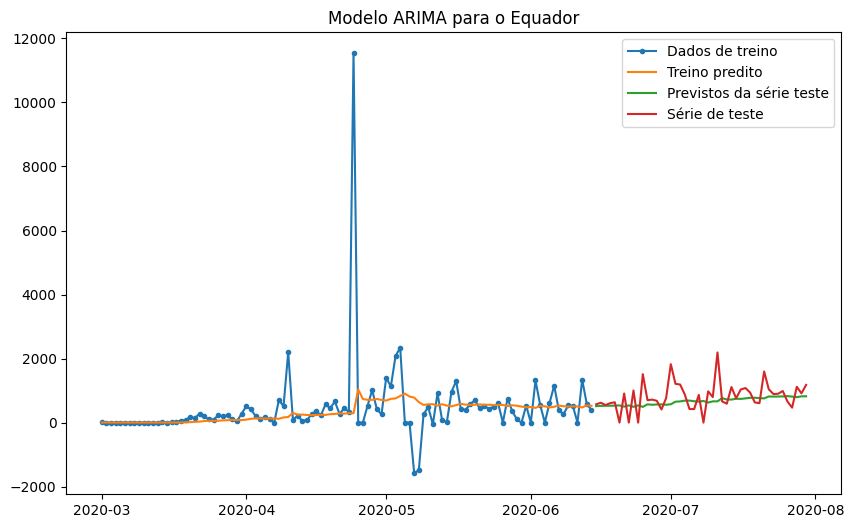

In [103]:
arima_model(train_data, test_data, p=1, d=1, q=3, model_name='ARIMA', country='Equador')

In [104]:
sarima_model = auto_arima(train_data,
                          start_p = 1, max_p = 7,
                          d = 1, max_d = 3,
                          start_q = 1, max_q = 7,
                          start_P = 1, max_P = 7,
                          D = 1, max_D = 3,
                          start_Q = 1, max_Q = 7,
                          m = 7, 
                          max_order = 14*3,
                          seasonal = True,
                          erro_action = 'warn',
                          trace = False,
                          supress_warnings = True,
                          stepwise = True,
                          random_state = 21,
                          n_fits = 100
                          )

In [105]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  106
Model:             SARIMAX(2, 1, 1)x(6, 1, 1, 7)   Log Likelihood                -843.567
Date:                           Wed, 18 Jan 2023   AIC                           1709.134
Time:                                   21:25:00   BIC                           1737.569
Sample:                               03-01-2020   HQIC                          1720.635
                                    - 06-14-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0606      0.106      0.574      0.566      -0.146       0.268
ar.L2         -0.0004      0.147     -0.003      0.998      -0.288       0.287
ma.L1         -0.9842      0.287     -3.425      0.001      -1.547      -0.421
ar.S.L7       -0.0860      0.169     -0.509      0.611      -0.417       0.245
ar.S.L14      -0.0837      0.131     -0.639      0.523      -0.340       0.173
ar.S.L21      -0.0421      0.166     -0.253      0.800      -0.368       0.284
ar.S.L28      -0.1356      0.355     -0.382      0.702      -0.831       0.560
ar.S.L35      -0.1420      0.174     -0.818      0.413      -0.482       0.198
ar.S.L42      -0.1471      0.406     -0.363      0.717      -0.942       0.648
ma.S.L7       -0.9180      0.303     -3.029      0.002      -1.512      -0.324
sigma2      1.408e+06    1.8e-07   7.81e+12      0.000    1.41e+06    1.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             11079.38
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                             5.96
Prob(H) (two-sided):                  0.02   Kurtosis:                        53.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.23e+28. Standard errors may be unstable.
"""

                                    SARIMAX Results                                    
Dep. Variable:                   New_Confirmed   No. Observations:                  106
Model:             ARIMA(2, 1, 1)x(6, 1, 1, 7)   Log Likelihood                -843.567
Date:                         Wed, 18 Jan 2023   AIC                           1709.134
Time:                                 21:27:53   BIC                           1737.569
Sample:                             03-01-2020   HQIC                          1720.635
                                  - 06-14-2020                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0606      0.106      0.574      0.566      -0.146       0.268
ar.L2         -0.0004      0.147     -0.003      0.998     

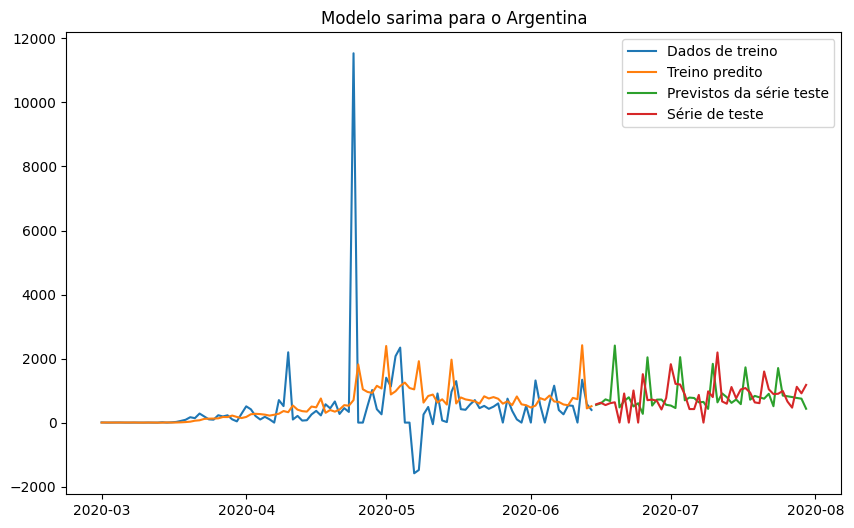

In [106]:
sarima_model_plot(train_data, test_data, p=2, d=1, q=1, P=6, D=1, Q=1, m=7, country='Argentina', model_name='sarima')

### Espanha

#### Preparação dos dados

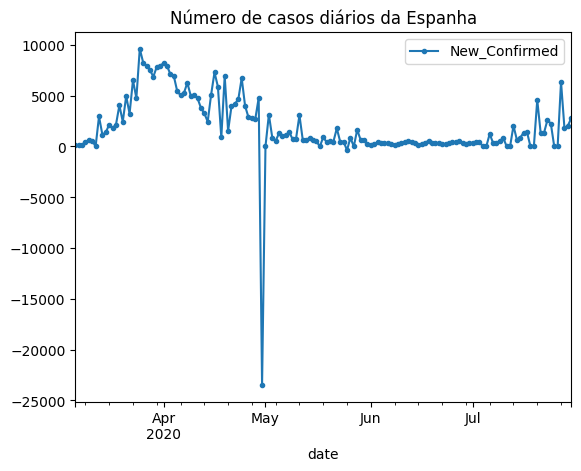

In [107]:
reg_data_es = read_data('ES')
reg_data_es = reg_data_es.loc[reg_data_es.ge(100).idxmax()[0]:]
reg_data_es.plot(marker='.')
plt.title('Número de casos diários da Espanha');

In [108]:
print('Total de registros:', len(reg_data_es))
print('Número de registros para treino:', round(len(reg_data_es)*0.7, 0))
print('Número de registros para teste:', round(len(reg_data_es)*0.3, 0))

Total de registros: 147
Número de registros para treino: 103.0
Número de registros para teste: 44.0


In [109]:
train_data = reg_data_es.iloc[:103]
test_data = reg_data_es.iloc[103:]
print('Número de registros para treino final:', len(train_data))
print('Número de registros para teste final:', len(test_data))

Número de registros para treino final: 103
Número de registros para teste final: 44


#### Modelo AR

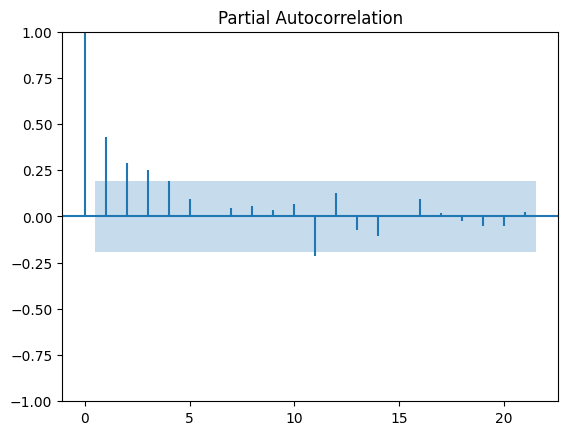

In [110]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train_data['New_Confirmed'], marker='');

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                  103
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -977.400
Date:                Wed, 18 Jan 2023   AIC                           1962.800
Time:                        21:30:53   BIC                           1973.339
Sample:                    03-06-2020   HQIC                          1967.069
                         - 06-16-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2369.6019   1306.777      1.813      0.070    -191.634    4930.838
ar.L1          0.3058      0.078      3.930      0.000       0.153       0.458
ar.L2          0.2806      0.049      5.711      0.0

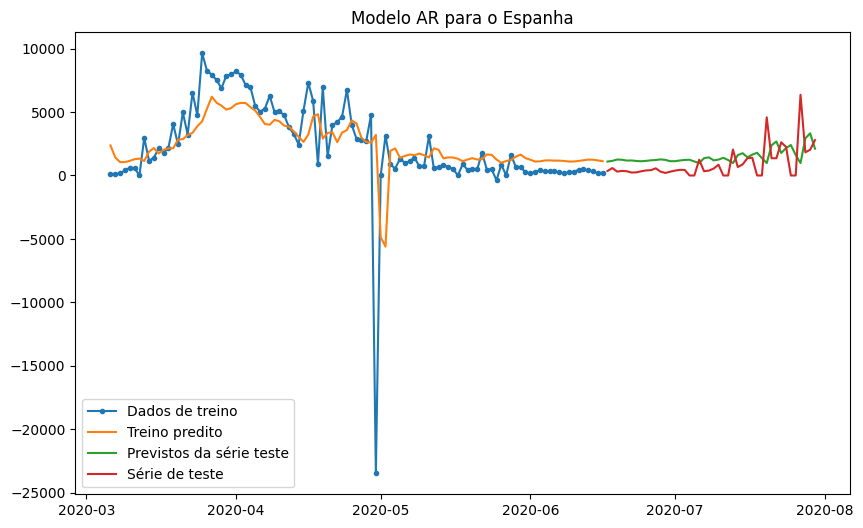

In [111]:
arima_model(train_data, test_data, p=2, model_name='AR', country='Espanha')

#### Modelo MA

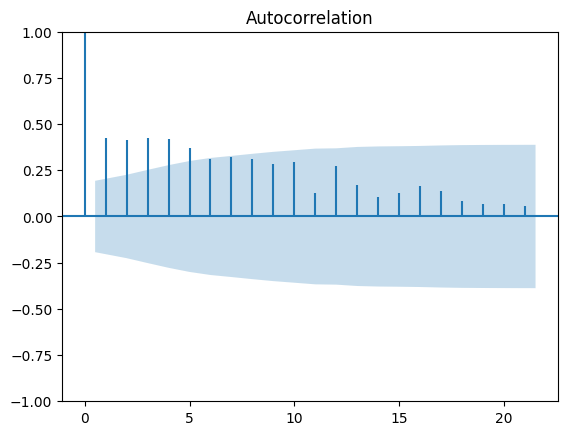

In [112]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train_data['New_Confirmed'], marker='');

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                  103
Model:                 ARIMA(0, 0, 8)   Log Likelihood                -977.140
Date:                Wed, 18 Jan 2023   AIC                           1974.280
Time:                        21:31:18   BIC                           2000.628
Sample:                    03-06-2020   HQIC                          1984.952
                         - 06-16-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2369.6019   1915.679      1.237      0.216   -1385.061    6124.265
ma.L1          0.2053      0.192      1.069      0.285      -0.171       0.582
ma.L2          0.1718      0.141      1.221      0.2

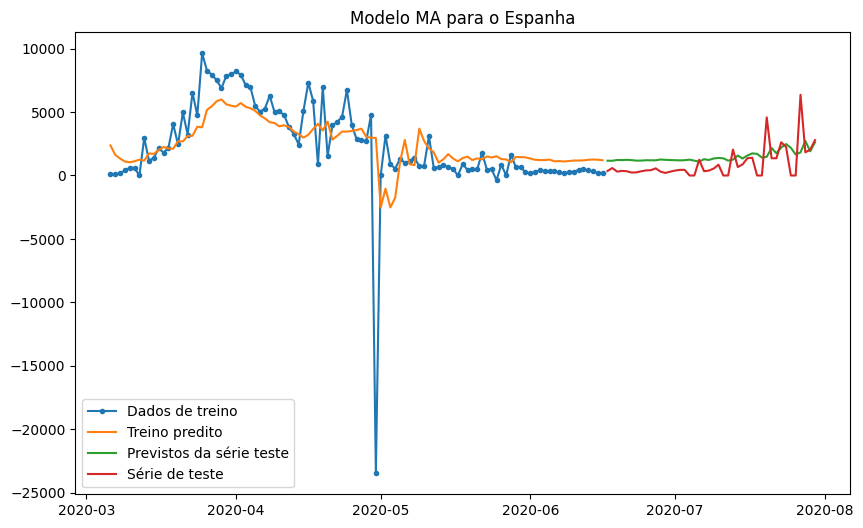

In [113]:
arima_model(train_data, test_data, q=8, model_name='MA', country='Espanha')

#### Modelo ARIMA

ADF Statistic 0 Order: -2.239711
p-value: 0.192149
ADF Statistic 1st Order: -9.801334
p-value: 0.000000
ADF Statistic 2nd Order: -7.457580
p-value: 0.000000
ADF Statistic 3th order: -6.745130
p-value: 0.000000


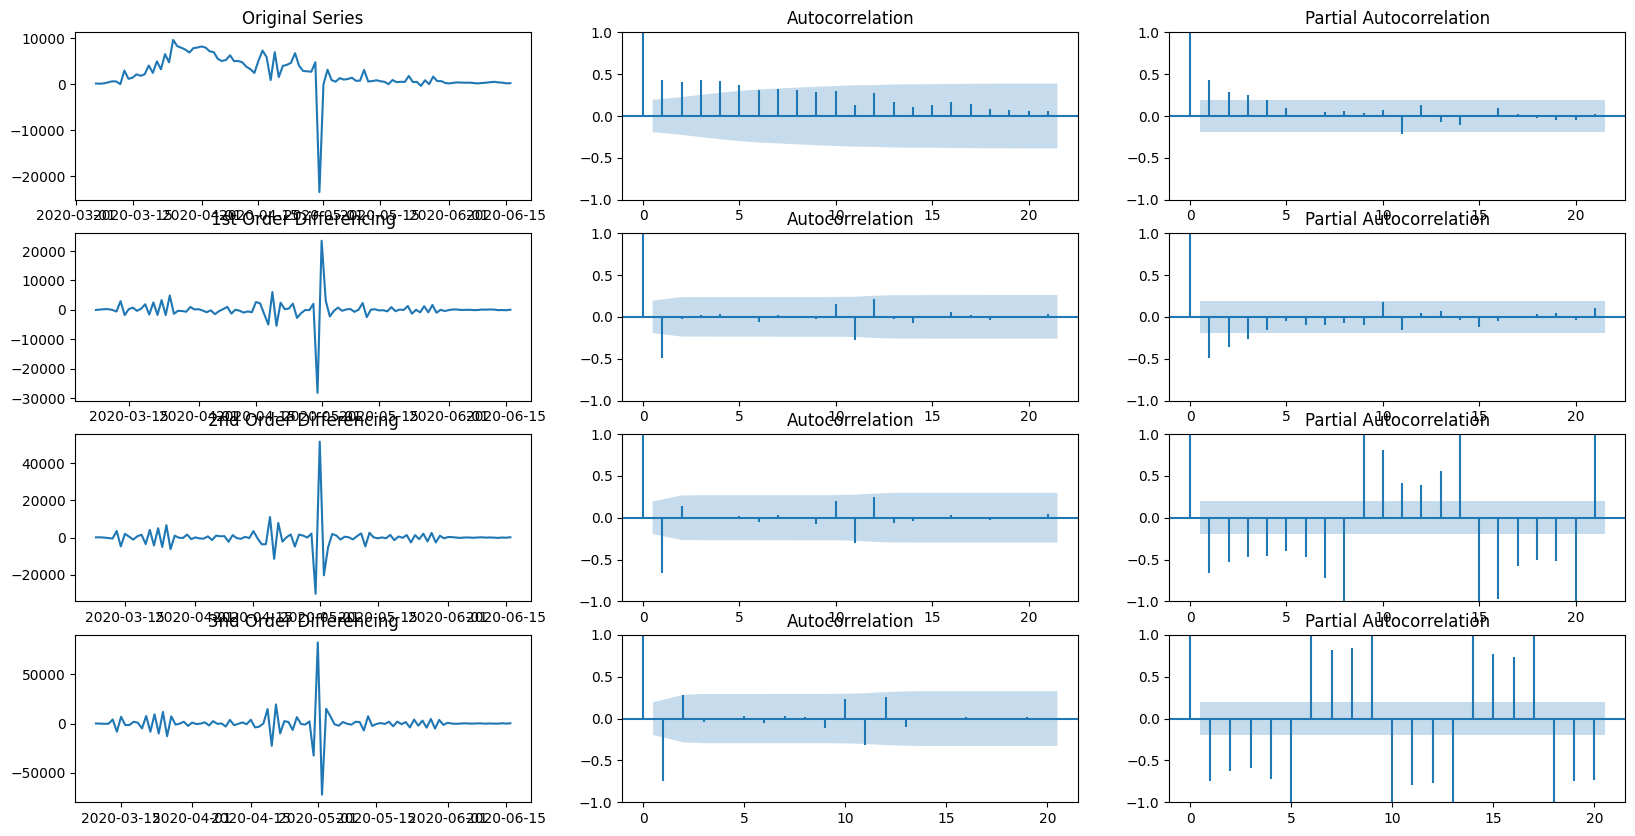

In [114]:
plot_diffs()

                               SARIMAX Results                                
Dep. Variable:          New_Confirmed   No. Observations:                  103
Model:                 ARIMA(3, 1, 5)   Log Likelihood                -963.939
Date:                Wed, 18 Jan 2023   AIC                           1945.878
Time:                        21:31:48   BIC                           1969.503
Sample:                    03-06-2020   HQIC                          1955.445
                         - 06-16-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8539      4.668     -0.183      0.855     -10.004       8.296
ar.L2         -0.8073      1.380     -0.585      0.559      -3.513       1.898
ar.L3         -0.8658      3.952     -0.219      0.8

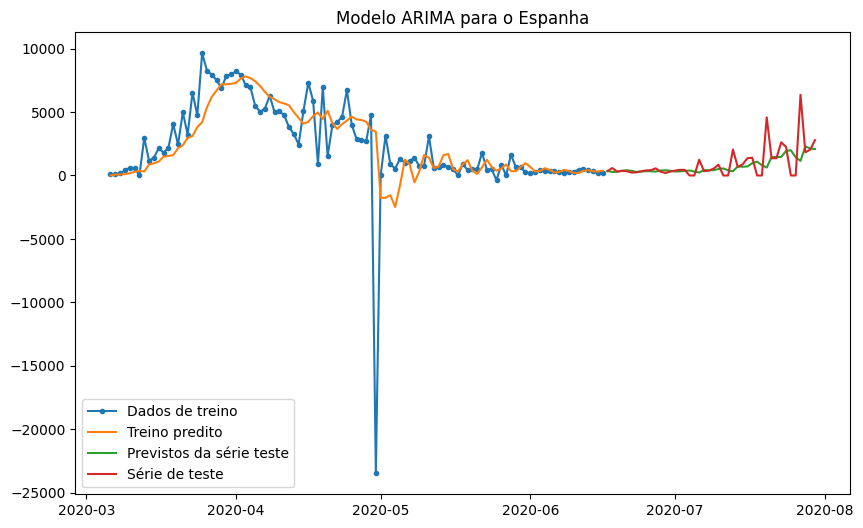

In [115]:
arima_model(train_data, test_data, p=3, d=1, q=5, model_name='ARIMA', country='Espanha', save_model='ES')

In [117]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  103
Model:             SARIMAX(0, 1, 1)x(6, 1, 1, 7)   Log Likelihood                -905.285
Date:                           Wed, 18 Jan 2023   AIC                           1828.570
Time:                                   21:35:09   BIC                           1851.554
Sample:                               03-06-2020   HQIC                          1837.857
                                    - 06-16-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7484      0.101     -7.402      0.000      -0.947      -0.550
ar.S.L7       -0.1055      0.404     -0.261      0.794      -0.897       0.687
ar.S.L14      -0.1971      0.425     -0.464      0.643      -1.030       0.636
ar.S.L21      -0.0854      0.379     -0.225      0.822      -0.828       0.658
ar.S.L28      -0.1783      0.562     -0.317      0.751      -1.280       0.923
ar.S.L35      -0.1410      0.770     -0.183      0.855      -1.651       1.369
ar.S.L42      -0.1406      0.795     -0.177      0.860      -1.699       1.418
ma.S.L7       -0.8725      0.495     -1.763      0.078      -1.843       0.098
sigma2      9.603e+06   2.89e-07   3.33e+13      0.000     9.6e+06     9.6e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             11755.45
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -6.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        55.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.92e+29. Standard errors may be unstable.
"""

                                    SARIMAX Results                                    
Dep. Variable:                   New_Confirmed   No. Observations:                  103
Model:             ARIMA(0, 1, 1)x(6, 1, 1, 7)   Log Likelihood                -905.285
Date:                         Wed, 18 Jan 2023   AIC                           1828.570
Time:                                 21:36:39   BIC                           1851.554
Sample:                             03-06-2020   HQIC                          1837.857
                                  - 06-16-2020                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7484      0.101     -7.402      0.000      -0.947      -0.550
ar.S.L7       -0.1055      0.404     -0.261      0.794     

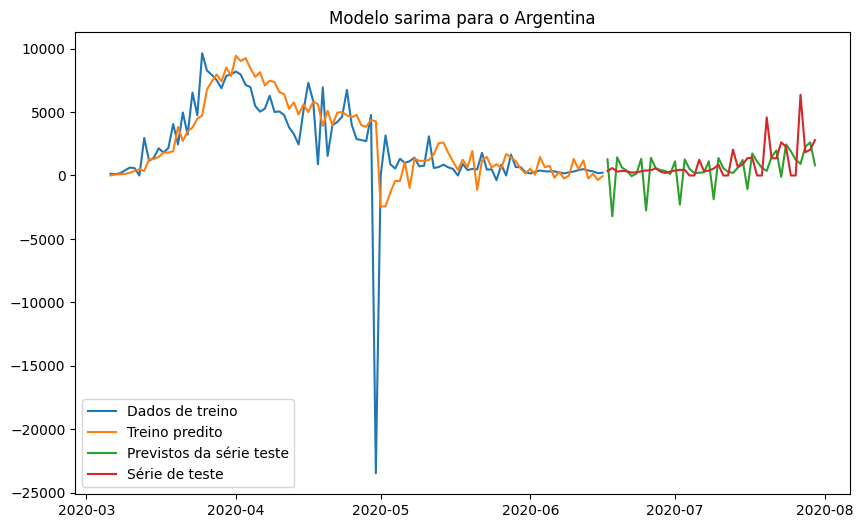

In [118]:
sarima_model_plot(train_data, test_data, p=0, d=1, q=1, P=6, D=1, Q=1, m=7, country='Argentina', model_name='sarima')